# 2. Analyse des Biais Ethniques et Raciaux

Ce notebook analyse la représentation des différents groupes ethniques dans les scripts de films (1960-2020) :

1. **Fréquence des mentions** : Quels groupes ethniques sont mentionnés ?
2. **Stéréotypes raciaux** : Associations négatives (criminalité, pauvreté, exotisme)
3. **Évolution temporelle** : Comment la représentation a-t-elle évolué ?
4. **Intersectionnalité** : Croisement avec le genre
5. **Analyse de contexte** : Mots co-occurrents avec les mentions ethniques

In [1]:
# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import Counter

# Nos modules
from dictionaries import ETHNICITY_WORDS, RACIAL_STEREOTYPES
from stats_analysis import (
    analyze_racial_bias_by_decade,
    calculate_relative_frequency,
    compare_decades
)

# Configuration des graphiques
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports réussis")

✓ Imports réussis


## 1. Chargement des Données

In [2]:
# Charger les données nettoyées
data_path = Path('../data/processed/scripts_clean.pkl')

if not data_path.exists():
    raise FileNotFoundError(
        "Fichier scripts_clean.pkl introuvable. "
        "Veuillez d'abord exécuter le notebook 0_clean_data.ipynb"
    )

df = pd.read_pickle(data_path)
print(f"✓ {len(df)} scripts chargés")
print(f"  Période : {df['release_year'].min():.0f} - {df['release_year'].max():.0f}")

✓ 1787 scripts chargés
  Période : 1960 - 2020


## 2. Analyse par Décennie

In [3]:
# Analyser les biais raciaux par décennie
df_racial = analyze_racial_bias_by_decade(
    df,
    text_column='clean_text',
    year_column='release_year'
)

print("=== Résultats par décennie ===")
display(df_racial)

=== Résultats par décennie ===


,decade,num_scripts,african_american_freq,asian_freq,hispanic_freq,white_freq,native_freq,middle_eastern_freq,stereotype_criminal_freq,stereotype_exotic_freq,stereotype_poverty_freq
0,1960,34,0.331517,0.159163,0.035174,0.315688,0.021105,0.154767,0.112557,0.024622,0.096729
1,1970,80,0.530994,0.107228,0.113662,0.467086,0.036458,0.041176,0.103797,0.083638,0.097792
2,1980,187,0.498449,0.152079,0.056346,0.444364,0.051824,0.018280,0.122492,0.097051,0.069726
3,1990,378,0.557960,0.158416,0.066299,0.454316,0.054035,0.014569,0.134349,0.066760,0.070448
4,2000,521,0.533005,0.141323,0.076054,0.380201,0.037436,0.052465,0.128241,0.059841,0.066521
5,2010,575,0.518426,0.132817,0.054281,0.398385,0.033982,0.011414,0.119976,0.066344,0.069910
6,2020,12,0.661155,0.098538,0.047679,0.425936,0.038144,0.006357,0.104895,0.079466,0.050858


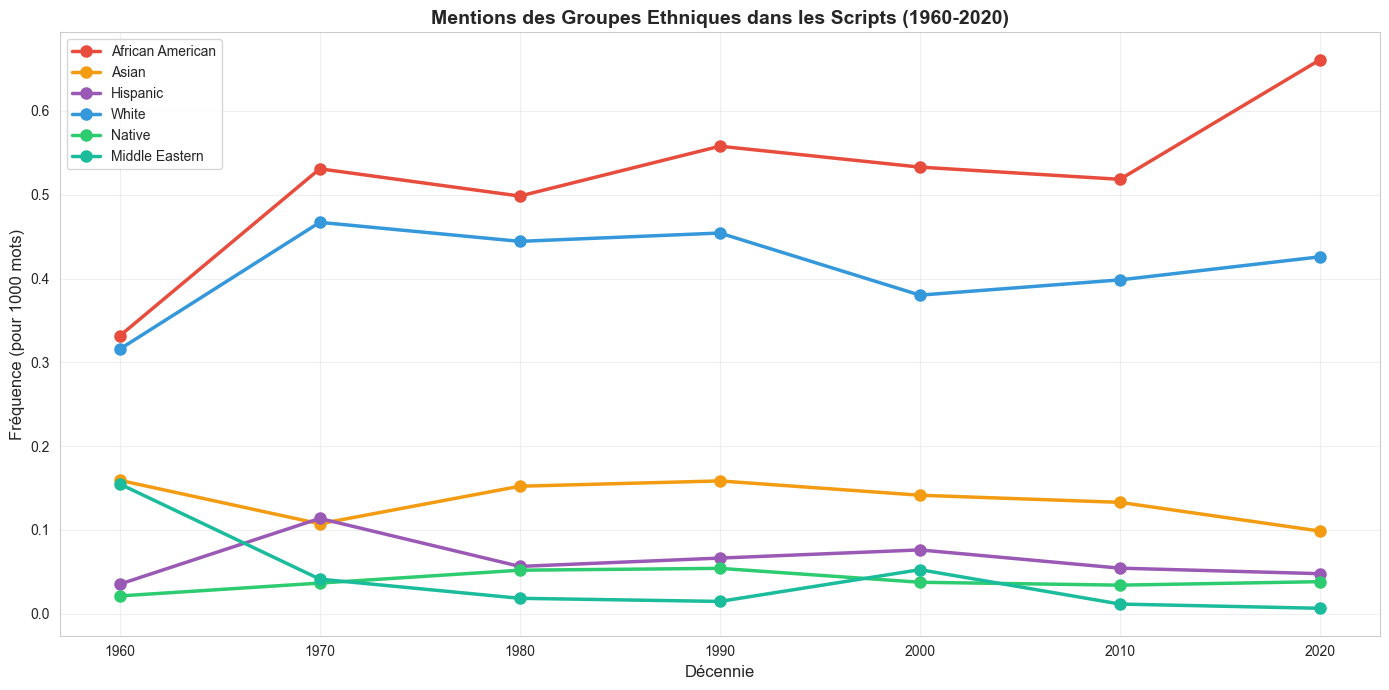

In [4]:
# Visualisation : Mentions des différents groupes ethniques
fig, ax = plt.subplots(figsize=(14, 7))

ethnic_groups = ['african_american', 'asian', 'hispanic', 'white', 'native', 'middle_eastern']
colors = ['#e74c3c', '#f39c12', '#9b59b6', '#3498db', '#2ecc71', '#1abc9c']

for group, color in zip(ethnic_groups, colors):
    col_name = f'{group}_freq'
    if col_name in df_racial.columns:
        ax.plot(df_racial['decade'], df_racial[col_name], 
                marker='o', linewidth=2.5, markersize=8, 
                label=group.replace('_', ' ').title(), color=color)

ax.set_xlabel('Décennie', fontsize=12)
ax.set_ylabel('Fréquence (pour 1000 mots)', fontsize=12)
ax.set_title('Mentions des Groupes Ethniques dans les Scripts (1960-2020)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/ethnic_mentions_by_decade.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Analyse des Stéréotypes Raciaux

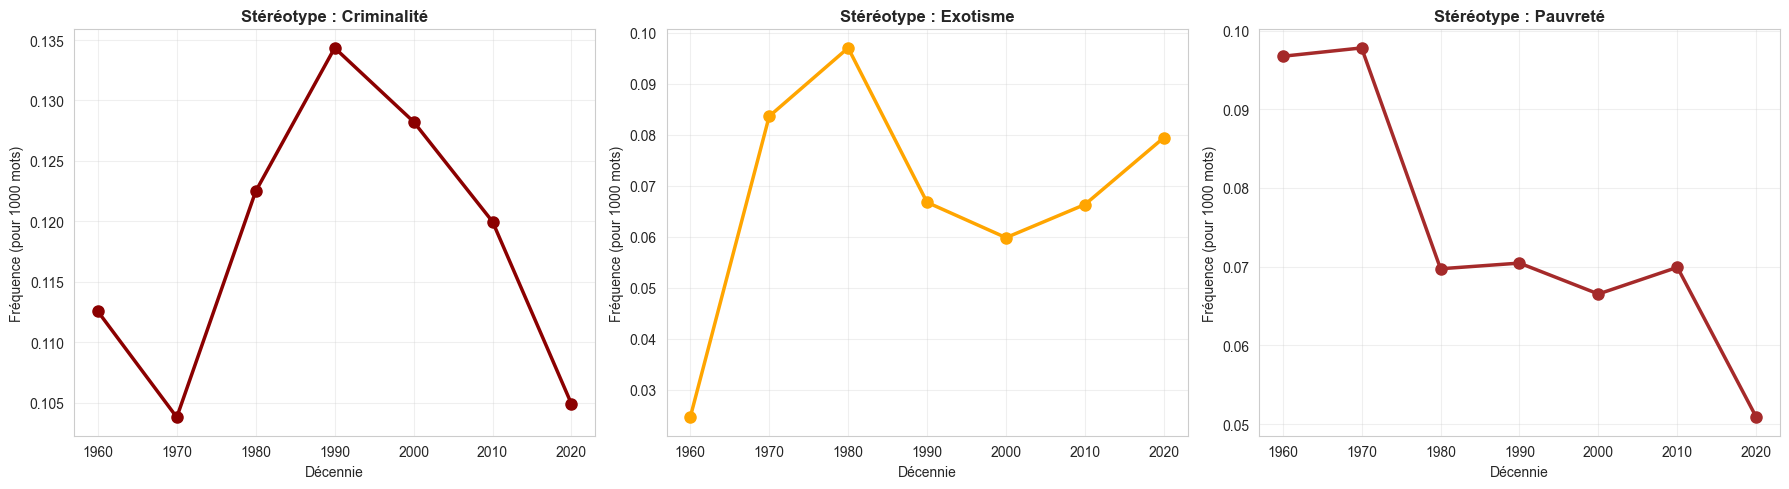

In [5]:
# Visualisation des stéréotypes raciaux
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

stereotypes = [
    ('stereotype_criminal_freq', 'Criminalité', 'darkred'),
    ('stereotype_exotic_freq', 'Exotisme', 'orange'),
    ('stereotype_poverty_freq', 'Pauvreté', 'brown')
]

for idx, (col, title, color) in enumerate(stereotypes):
    if col in df_racial.columns:
        axes[idx].plot(df_racial['decade'], df_racial[col], 
                      marker='o', linewidth=2.5, markersize=8, color=color)
        axes[idx].set_title(f'Stéréotype : {title}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Décennie')
        axes[idx].set_ylabel('Fréquence (pour 1000 mots)')
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/racial_stereotypes.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Ratio de Représentation

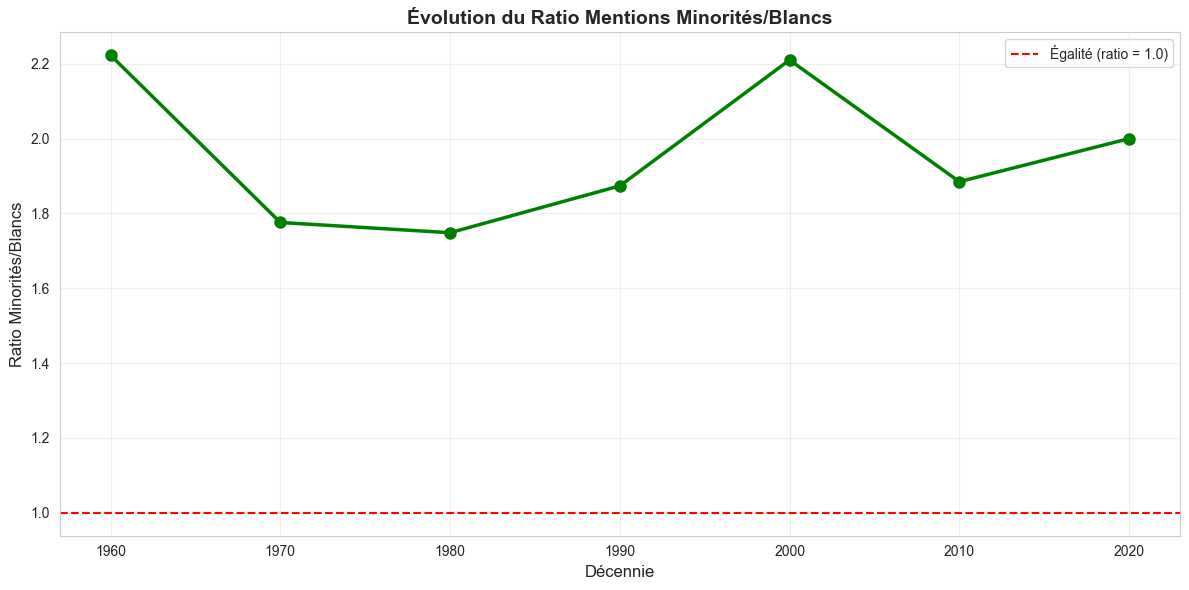

In [6]:
# Comparer la représentation entre groupes minoritaires et blancs
minorities = ['african_american', 'asian', 'hispanic', 'native', 'middle_eastern']

# Somme des mentions de minorités
minority_cols = [f'{m}_freq' for m in minorities if f'{m}_freq' in df_racial.columns]
df_racial['minorities_total'] = df_racial[minority_cols].sum(axis=1)

# Ratio minorités vs blancs
if 'white_freq' in df_racial.columns:
    df_racial['minority_white_ratio'] = df_racial['minorities_total'] / df_racial['white_freq'].replace(0, np.nan)

    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(df_racial['decade'], df_racial['minority_white_ratio'], 
            marker='o', linewidth=2.5, markersize=8, color='green')
    ax.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, 
               label='Égalité (ratio = 1.0)')
    
    ax.set_xlabel('Décennie', fontsize=12)
    ax.set_ylabel('Ratio Minorités/Blancs', fontsize=12)
    ax.set_title('Évolution du Ratio Mentions Minorités/Blancs', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/figures/minority_white_ratio.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5. Analyse de Contexte : Mots Co-occurrents

In [7]:
def find_cooccurring_words(text, target_words, window=5, top_n=20):
    """
    Trouve les mots qui apparaissent fréquemment autour des mots cibles.
    
    Args:
        text: Texte à analyser
        target_words: Liste de mots cibles
        window: Nombre de mots avant/après à considérer
        top_n: Nombre de mots les plus fréquents à retourner
    """
    if not isinstance(text, str):
        return []
    
    words = text.lower().split()
    cooccurring = []
    
    for i, word in enumerate(words):
        if any(target in word for target in target_words):
            # Extraire les mots dans la fenêtre
            start = max(0, i - window)
            end = min(len(words), i + window + 1)
            context_words = words[start:i] + words[i+1:end]
            
            # Filtrer les mots courts et stopwords basiques
            context_words = [w for w in context_words 
                           if len(w) > 3 and w.isalpha()]
            cooccurring.extend(context_words)
    
    # Compter les occurrences
    counter = Counter(cooccurring)
    return counter.most_common(top_n)


# Analyser les co-occurrences pour chaque groupe ethnique dans les années 2000-2020
recent_scripts = df[df['decade'] >= 2000]['clean_text'].str.cat(sep=' ')

print("=== MOTS ASSOCIÉS AUX GROUPES ETHNIQUES (2000-2020) ===")
print()

for group, words in ETHNICITY_WORDS.items():
    print(f"\n📊 {group.upper().replace('_', ' ')} :")
    cooccur = find_cooccurring_words(recent_scripts, words, window=5, top_n=15)
    
    for word, count in cooccur[:10]:
        print(f"   - {word} : {count}")

=== MOTS ASSOCIÉS AUX GROUPES ETHNIQUES (2000-2020) ===


📊 AFRICAN AMERICAN :
   - with : 1333
   - fade : 950
   - from : 786
   - into : 767
   - white : 676
   - over : 570
   - black : 548
   - that : 467
   - like : 361
   - they : 334

📊 ASIAN :
   - with : 416
   - from : 193
   - they : 158
   - that : 138
   - woman : 114
   - night : 111
   - like : 110
   - their : 104
   - this : 101
   - have : 97

📊 HISPANIC :
   - with : 200
   - from : 91
   - that : 88
   - into : 75
   - this : 67
   - woman : 66
   - like : 58
   - they : 55
   - down : 48
   - over : 48

📊 WHITE :
   - with : 1039
   - black : 773
   - house : 756
   - from : 412
   - white : 299
   - into : 292
   - that : 264
   - revision : 258
   - they : 242
   - script : 240

📊 NATIVE :
   - with : 147
   - they : 86
   - that : 78
   - from : 78
   - their : 64
   - have : 63
   - american : 59
   - like : 52
   - this : 48
   - other : 34

📊 MIDDLE EASTERN :
   - with : 122
   - from : 79
   - saudi : 64
  

## 6. Analyse par Film

In [8]:
# Calculer les métriques pour chaque film
print("Calcul des métriques par film...")

for group in ['african_american', 'asian', 'hispanic', 'white']:
    if group in ETHNICITY_WORDS:
        df[f'{group}_freq'] = df['clean_text'].apply(
            lambda x: calculate_relative_frequency(x, ETHNICITY_WORDS[group])
        )

# Stéréotypes
for stereotype in ['criminal', 'exotic', 'poverty']:
    if stereotype in RACIAL_STEREOTYPES:
        df[f'stereotype_{stereotype}'] = df['clean_text'].apply(
            lambda x: calculate_relative_frequency(x, RACIAL_STEREOTYPES[stereotype])
        )

print("✓ Métriques calculées")

Calcul des métriques par film...
✓ Métriques calculées


In [9]:
# Films avec le plus de diversité ethnique (multiples groupes mentionnés)
ethnic_cols = ['african_american_freq', 'asian_freq', 'hispanic_freq']
df['ethnic_diversity_score'] = df[ethnic_cols].sum(axis=1)

print("\n=== FILMS AVEC LE PLUS DE DIVERSITÉ ETHNIQUE ===")
print("(Somme des mentions de groupes minoritaires)\n")

top_diverse = df.nlargest(15, 'ethnic_diversity_score')[['title', 'release_year', 'ethnic_diversity_score']]
for idx, row in top_diverse.iterrows():
    print(f"📽️  {row['title']} ({row['release_year']:.0f}) - Score: {row['ethnic_diversity_score']:.2f}")


=== FILMS AVEC LE PLUS DE DIVERSITÉ ETHNIQUE ===
(Somme des mentions de groupes minoritaires)

📽️  Moonlight (2016) - Score: 11.79
📽️  Bamboozled (2000) - Score: 8.95
📽️  Sleuth (2007) - Score: 7.92
📽️  The Watermelon Woman (1996) - Score: 7.11
📽️  The Lego Movie (2014) - Score: 5.90
📽️  A Prayer Before Dawn (2017) - Score: 5.72
📽️  Rolling Thunder (1977) - Score: 5.34
📽️  Lost in Translation (2003) - Score: 5.16
📽️  Malcolm X (1992) - Score: 5.05
📽️  Thunderheart (1992) - Score: 5.02
📽️  Panther (1995) - Score: 4.87
📽️  Black Hawk Down (2001) - Score: 4.52
📽️  Harry Potter and the Prisoner of Azkaban (2004) - Score: 4.29
📽️  BlacKkKlansman (2018) - Score: 4.15
📽️  The Love Witch (2016) - Score: 4.10


/var/folders/nx/9n0zm1816l1gbyy2500y8d580000gn/T/ipykernel_57902/2923979068.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_diversity, x='decade', y='ethnic_diversity_score', ax=ax, palette='muted')


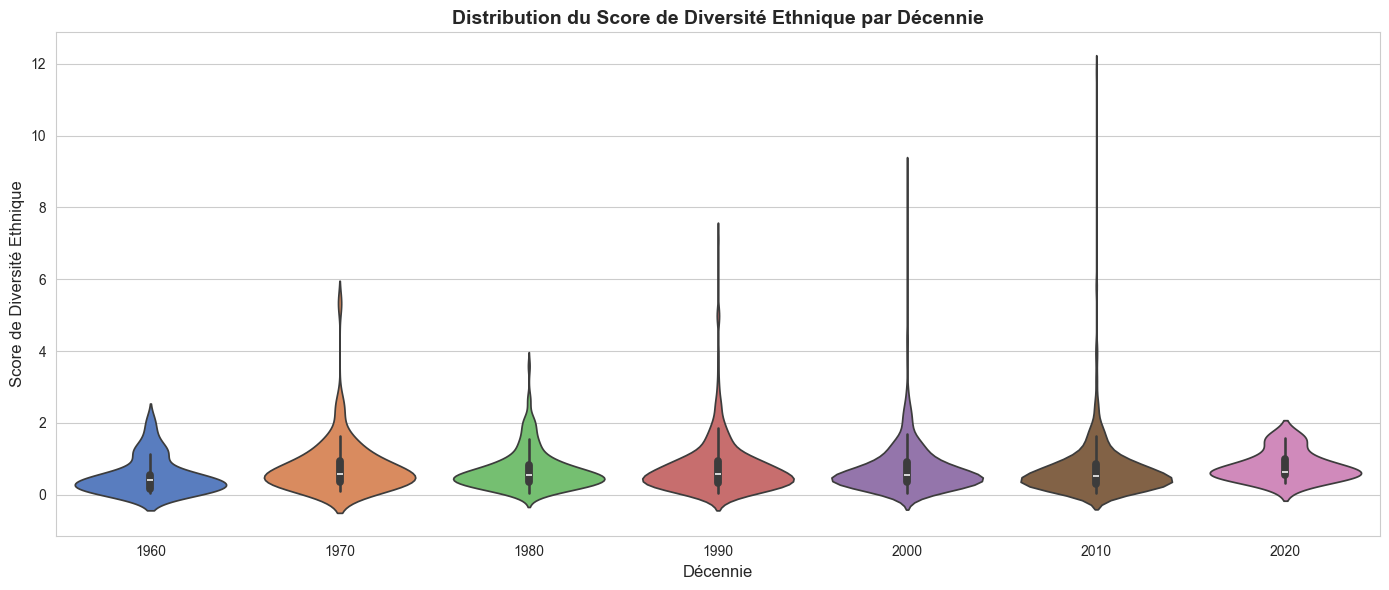

In [10]:
# Distribution de la diversité par décennie
fig, ax = plt.subplots(figsize=(14, 6))

df_diversity = df[df['ethnic_diversity_score'] > 0].copy()
sns.violinplot(data=df_diversity, x='decade', y='ethnic_diversity_score', ax=ax, palette='muted')

ax.set_xlabel('Décennie', fontsize=12)
ax.set_ylabel('Score de Diversité Ethnique', fontsize=12)
ax.set_title('Distribution du Score de Diversité Ethnique par Décennie', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/ethnic_diversity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Analyse Statistique des Tendances

In [11]:
# Analyser les tendances pour chaque groupe
print("=== ANALYSE DES TENDANCES (1960-2020) ===")
print()

metrics_to_analyze = [
    'african_american_freq',
    'asian_freq',
    'hispanic_freq',
    'white_freq',
    'stereotype_criminal_freq',
    'stereotype_exotic_freq'
]

for metric in metrics_to_analyze:
    if metric in df_racial.columns:
        trend = compare_decades(df_racial, metric)
        
        print(f"📊 {metric.upper().replace('_', ' ')}")
        print(f"   Évolution : {trend['first_value']:.2f} → {trend['last_value']:.2f}")
        print(f"   Changement : {trend['change']:+.2f} ({trend['percent_change']:+.1f}%)")
        print(f"   Tendance : {trend['trend'].upper()}")
        print()

=== ANALYSE DES TENDANCES (1960-2020) ===

📊 AFRICAN AMERICAN FREQ
   Évolution : 0.33 → 0.66
   Changement : +0.33 (+99.4%)
   Tendance : INCREASING

📊 ASIAN FREQ
   Évolution : 0.16 → 0.10
   Changement : -0.06 (-38.1%)
   Tendance : DECREASING

📊 HISPANIC FREQ
   Évolution : 0.04 → 0.05
   Changement : +0.01 (+35.6%)
   Tendance : DECREASING

📊 WHITE FREQ
   Évolution : 0.32 → 0.43
   Changement : +0.11 (+34.9%)
   Tendance : INCREASING

📊 STEREOTYPE CRIMINAL FREQ
   Évolution : 0.11 → 0.10
   Changement : -0.01 (-6.8%)
   Tendance : INCREASING

📊 STEREOTYPE EXOTIC FREQ
   Évolution : 0.02 → 0.08
   Changement : +0.05 (+222.7%)
   Tendance : INCREASING



## 8. Sauvegarde des Résultats

In [12]:
# Sauvegarder les résultats
output_dir = Path('../results')
output_dir.mkdir(exist_ok=True)

df_racial.to_csv(output_dir / 'ethnic_bias_by_decade.csv', index=False)
print(f"✓ Résultats sauvegardés : {output_dir / 'ethnic_bias_by_decade.csv'}")

# Données par film
ethnic_film_cols = ['title', 'release_year', 'decade'] + \
                   [col for col in df.columns if 'african_american' in col or 'asian' in col or 
                    'hispanic' in col or 'stereotype' in col or 'ethnic_diversity' in col]

df_films_ethnic = df[ethnic_film_cols].copy()
df_films_ethnic.to_csv(output_dir / 'ethnic_bias_by_film.csv', index=False)
print(f"✓ Données par film : {output_dir / 'ethnic_bias_by_film.csv'}")

print("\n✅ Analyse des biais ethniques terminée !")

✓ Résultats sauvegardés : ../results/ethnic_bias_by_decade.csv
✓ Données par film : ../results/ethnic_bias_by_film.csv

✅ Analyse des biais ethniques terminée !


## 9. Résumé et Conclusions

### Observations principales

À compléter après exécution :

- **Représentation** : Les personnages blancs sont mentionnés [X] fois plus souvent
- **Évolution** : La diversité ethnique a [augmenté/diminué/stagné]
- **Stéréotypes** : Les associations négatives (criminalité, pauvreté) ont [évolué comment ?]
- **Contexte** : Les mots associés aux différents groupes révèlent [quels patterns ?]

### Questions pour approfondir

1. Y a-t-il des différences entre films américains et internationaux ?
2. Les réalisateurs issus de minorités représentent-ils différemment les groupes ethniques ?
3. Comment la représentation varie-t-elle selon les genres de films ?